In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import os
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# path = './chosen_models.csv'
path = '../../csv_results/chosen_models.csv'
df = pd.read_csv(path)
df = df.fillna("None")
ids = df['id'].to_list()

In [3]:
ids

[6, 1, 3, 17, 16, 12, 29, 21, 22]

In [4]:
# Assuming your models are in the 'models' directory and have names like 'model6.h5', 'model1.h5', etc.
# models_dir = '../models/top10/'
models_dir = '../../../models/top10/'

# Create an empty dictionary to store the loaded models
loaded_models = {}

for id in ids:
    model_path = os.path.join(models_dir, f'{id}.h5')
    if os.path.exists(model_path):
        loaded_models[id] = tf.keras.models.load_model(model_path)
        print(f'Loaded model {id}')
    else:
        print(f"No model found for id {id}")

Loaded model 6
Loaded model 1
Loaded model 3
Loaded model 17
Loaded model 16
Loaded model 12
Loaded model 29
Loaded model 21
Loaded model 22


# Functions

In [5]:
# data_dir = '../dataset/realworld_test_data/processed/version1/'
data_dir = '../../../dataset/realworld_test_data/processed/version2/'

IMAGE_SIZE = 300
class_names = sorted(os.listdir(data_dir))
n_classes = len(class_names)

print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


In [6]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
#     # Convert image data type to tf.float32
#     image = tf.cast(image, tf.float32)
    
    return image, label

In [7]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False, verbose=1):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 5.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (20, 20).
        model (tf.keras.Model): A trained TensorFlow model to make predictions on the images. Default is None.
        check (bool): If True and a model is provided, only incorrectly predicted images will be plotted. Default is False.
    """
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Initialize image counter
    image_count = 0
    
    # Loop over all batches in dataset
    for images, labels in dataset:
        
        # Loop over all images in batch
        for i in range(images.shape[0]):
            
            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis], verbose=verbose)

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, image_count+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Increment image counter
            image_count += 1
            
            # Check if maximum number of images has been reached
            if image_count >= n_rows * n_cols:
                break
        
        # Check if maximum number of images has been reached
        if image_count >= n_rows * n_cols:
            break
    
    # Show the plot
    plt.show()

In [8]:
def plot_confusion_m(y_true, y_pred, class_names=None, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [9]:
# Calculate class distribution
class_dis = [len(os.listdir(data_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

In [10]:
real_test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir)
real_test_ds_mapped = real_test_ds.map(load_and_preprocess_image)
real_test_ds_mapped.prefetch(tf.data.AUTOTUNE)

Found 740 files belonging to 20 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

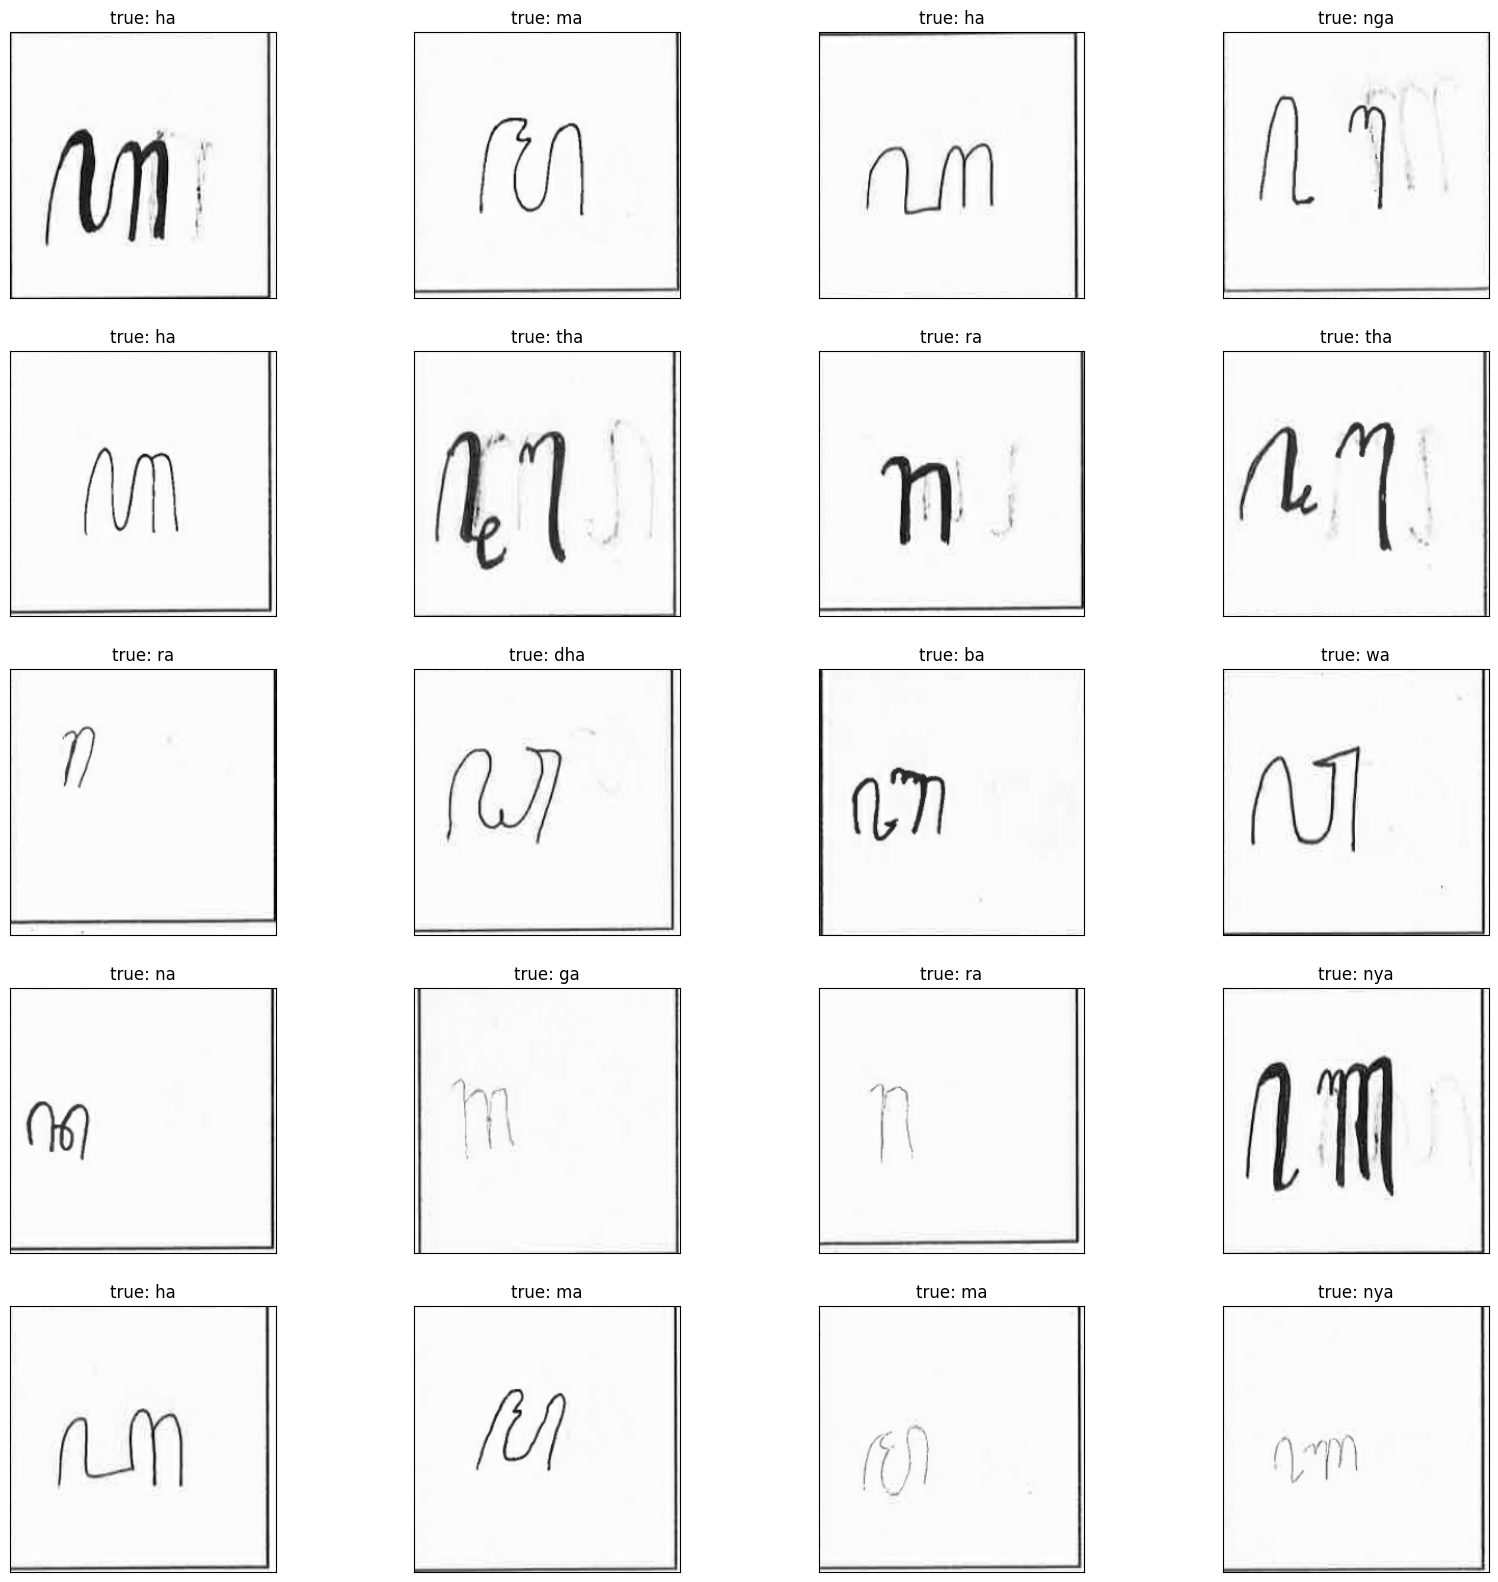

In [11]:
plot_images(real_test_ds)

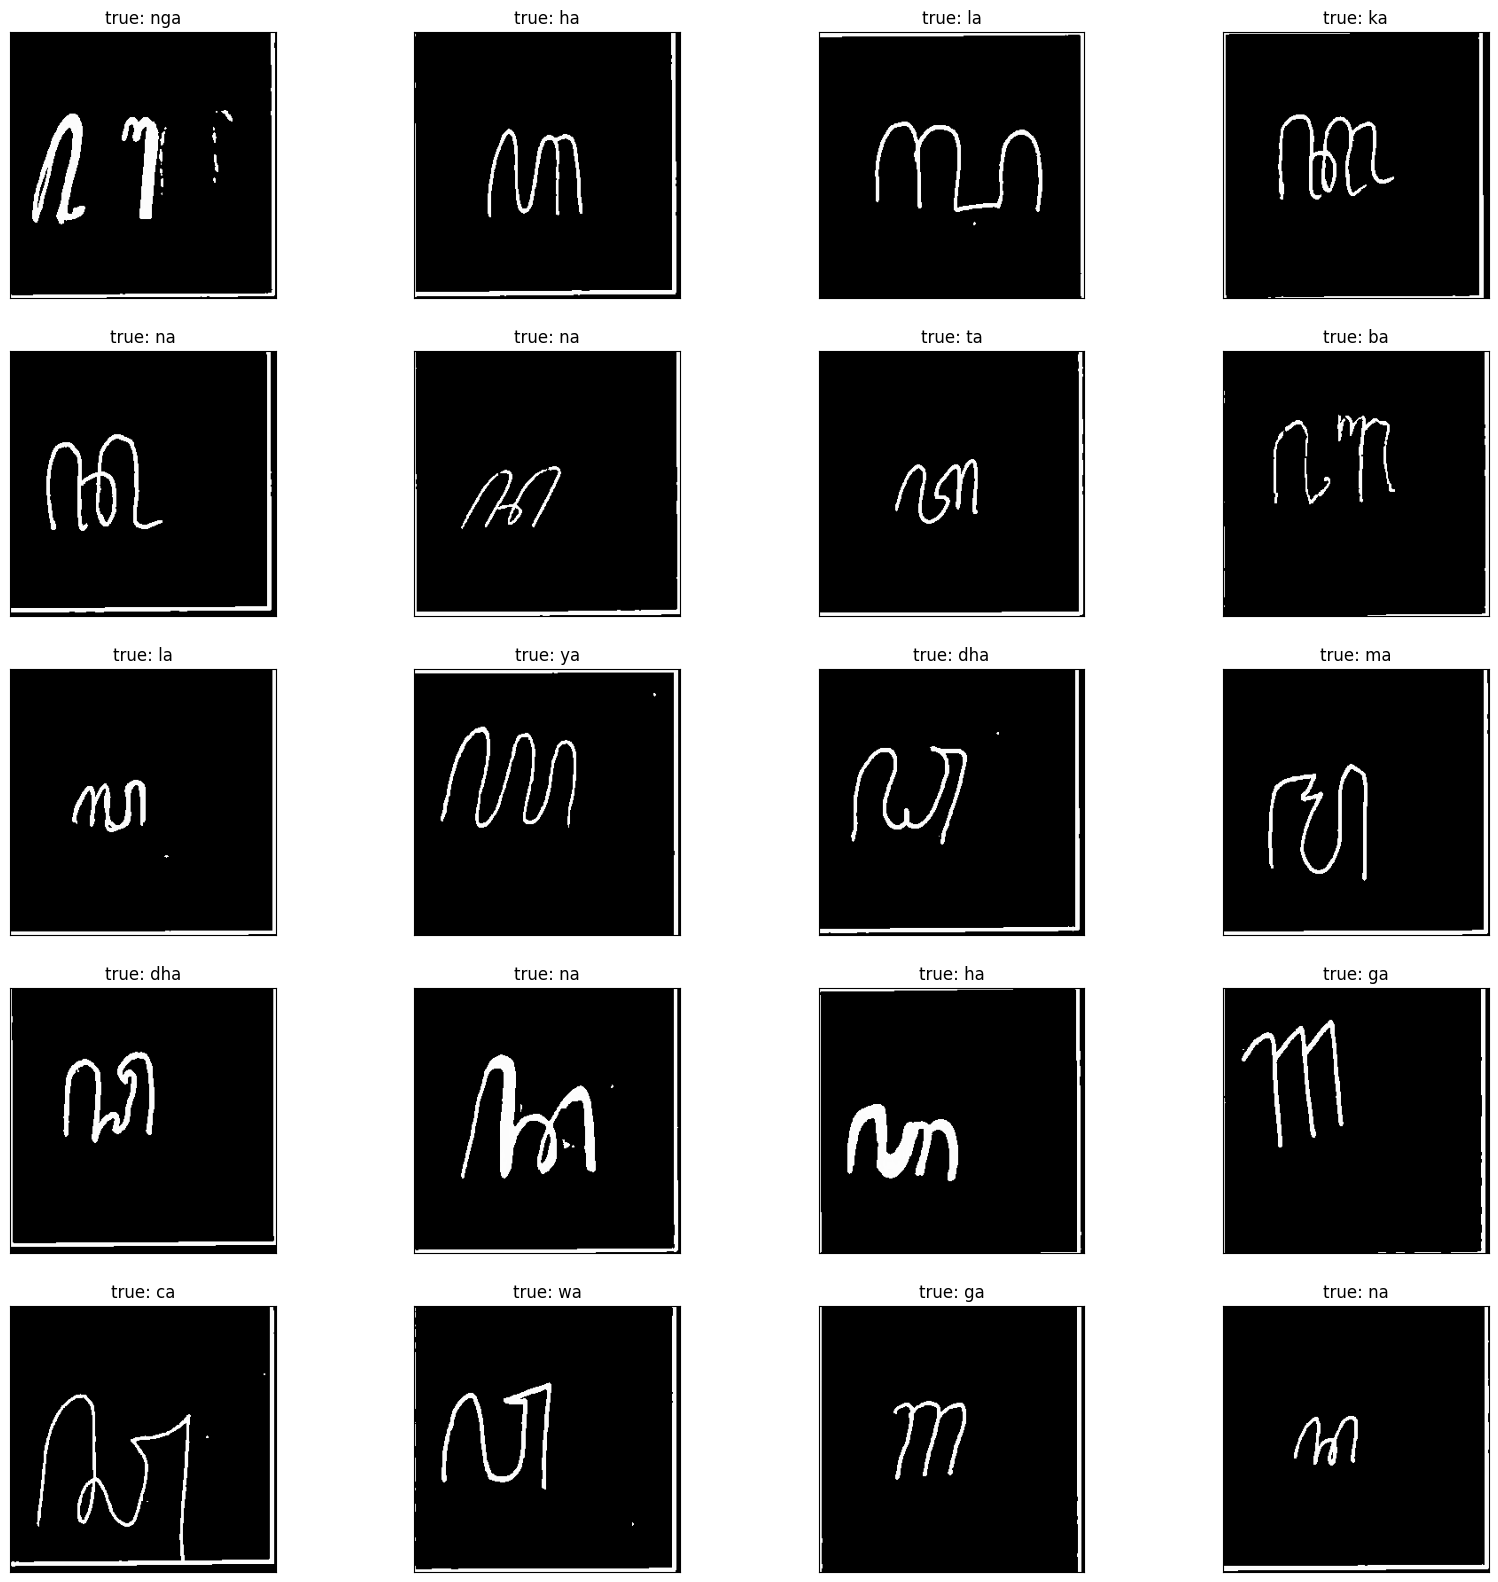

In [12]:
plot_images(real_test_ds_mapped)

In [13]:
results = pd.DataFrame(columns=['model_id', 'loss', 'accuracy'])

for id, model in loaded_models.items():
   
   print(f'START predicting with model {id} ...')
   
   # y_pred = []  # store predicted labels
   # y_true = []  # store true labels

   # # iterate over the dataset
   # for image_batch, label_batch in real_test_ds_mapped:   # use dataset.unbatch() with repeat
   #    # append true labels
   #    y_true.append(label_batch)
   #    # compute predictions
   #    preds = model.predict(image_batch, verbose=0)
   #    # append predicted labels
   #    y_pred.append(np.argmax(preds, axis = - 1))

   # # convert the true and predicted labels into tensors
   # correct_labels = tf.concat([item for item in y_true], axis = 0)
   # predicted_labels = tf.concat([item for item in y_pred], axis = 0)

   # print(f'==== CONFUSION MATRIX FOR MODEL {id} ====')
   # plot_confusion_m(correct_labels, predicted_labels, class_names, figsize=(8,8))
   
   loss, acc = model.evaluate(real_test_ds_mapped)
   print("Loss    : {:.4}".format(loss))
   print("Accuracy: {:.4}%".format(acc*100))
   
   result_df = pd.DataFrame({'model_id': [id], 'loss': [loss], 'accuracy': [acc]})
   results = pd.concat([results, result_df], ignore_index=True)
   
   print(f'FINISHED predicting with model {id} ... \n')

START predicting with model 6 ...
24/24 [==============================] - 100s 4s/step - loss: 1.4902 - accuracy: 0.5811
Loss    : 1.49
Accuracy: 58.11%
FINISHED predicting with model 6 ... 

START predicting with model 1 ...
24/24 [==============================] - 94s 4s/step - loss: 0.4060 - accuracy: 0.9000
Loss    : 0.406
Accuracy: 90.0%
FINISHED predicting with model 1 ... 

START predicting with model 3 ...
24/24 [==============================] - 87s 4s/step - loss: 0.8170 - accuracy: 0.8257
Loss    : 0.817
Accuracy: 82.57%
FINISHED predicting with model 3 ... 

START predicting with model 17 ...
24/24 [==============================] - 288s 11s/step - loss: 1.4602 - accuracy: 0.7959
Loss    : 1.46
Accuracy: 79.59%
FINISHED predicting with model 17 ... 

START predicting with model 16 ...
24/24 [==============================] - 249s 10s/step - loss: 1.1103 - accuracy: 0.6824
Loss    : 1.11
Accuracy: 68.24%
FINISHED predicting with model 16 ... 

START predicting with model 12

# Check Errors

==== MODEL 6 ====


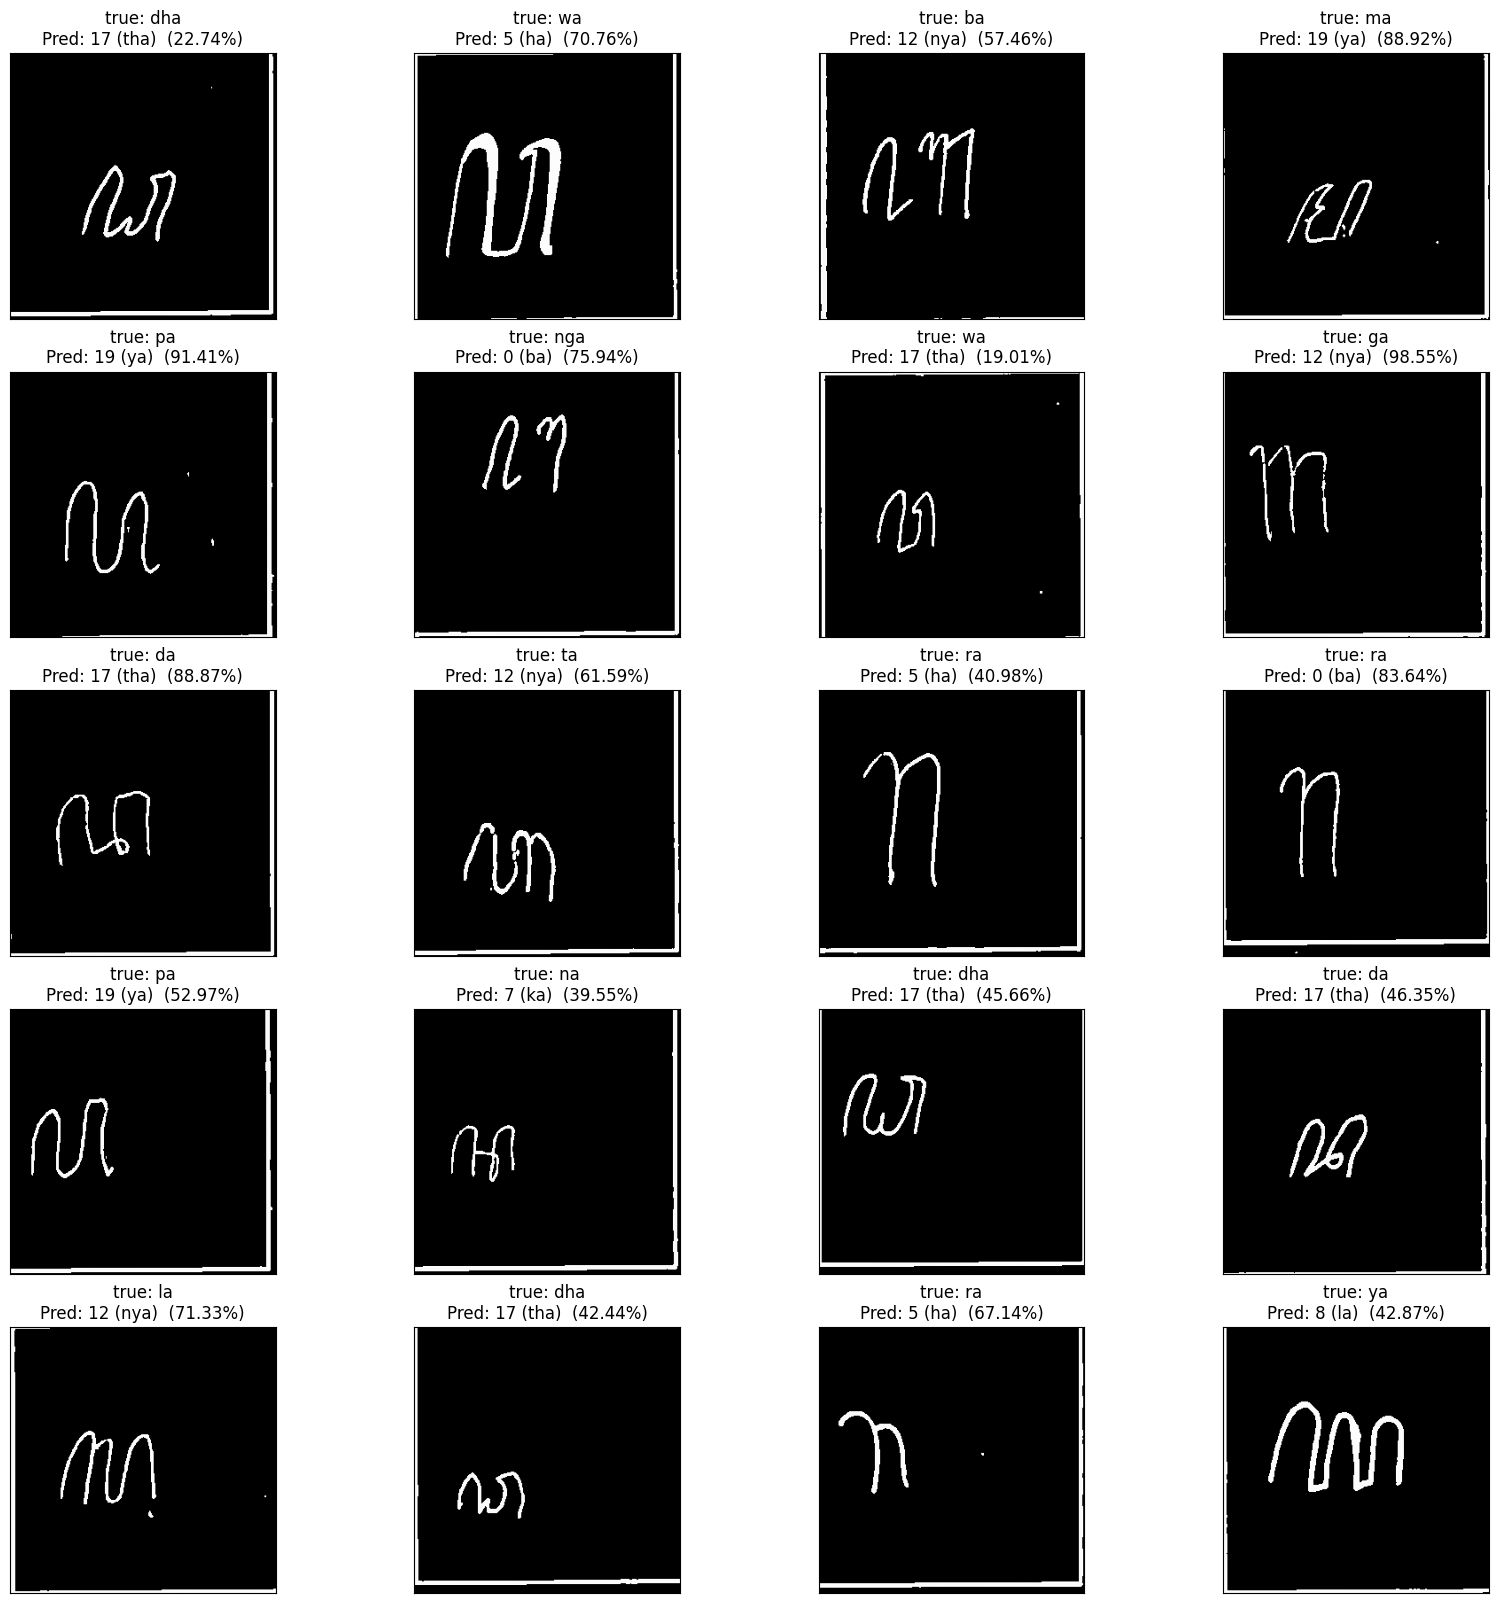

==== END MODEL 6 ====


==== MODEL 1 ====


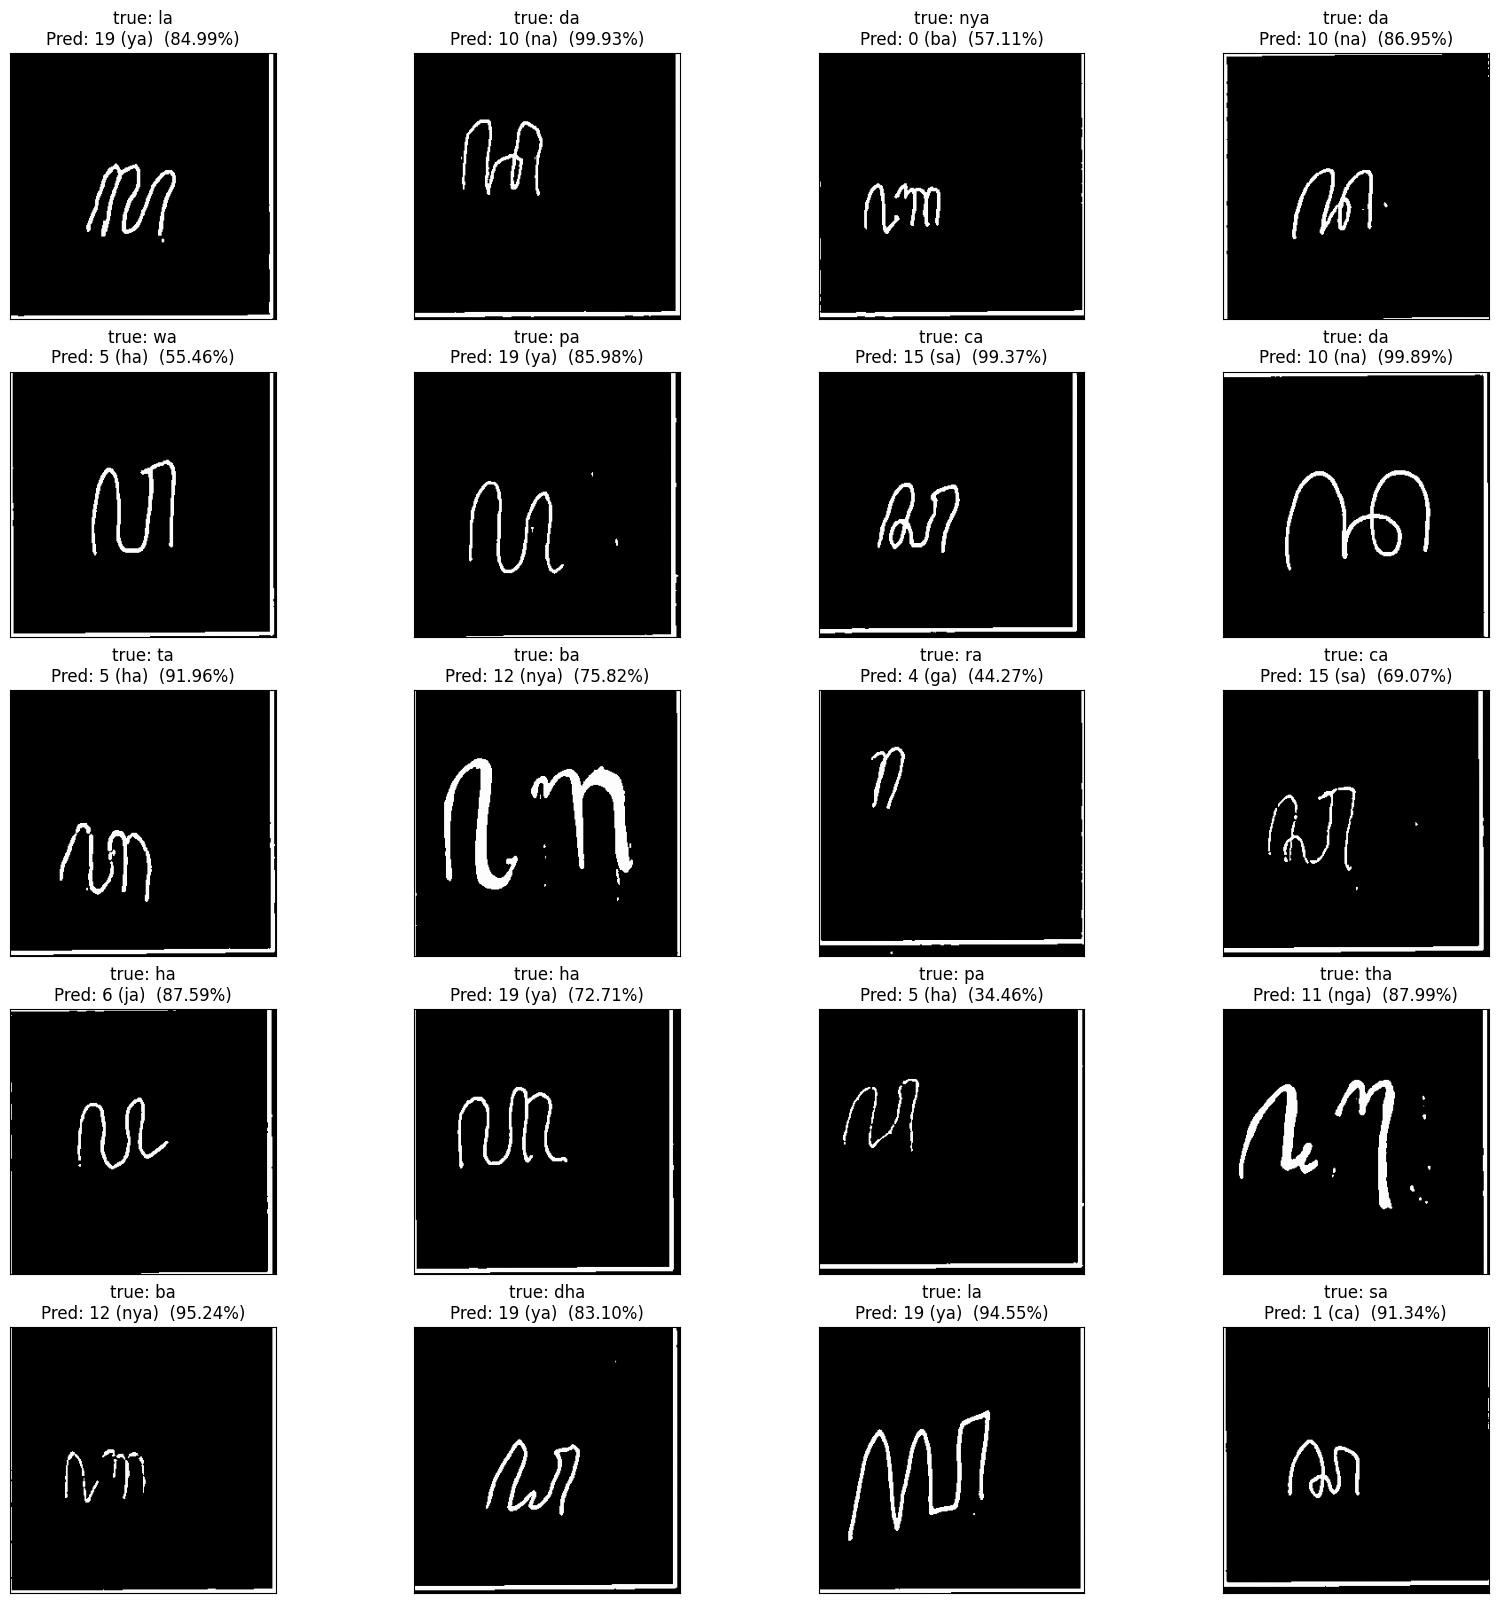

==== END MODEL 1 ====


==== MODEL 3 ====


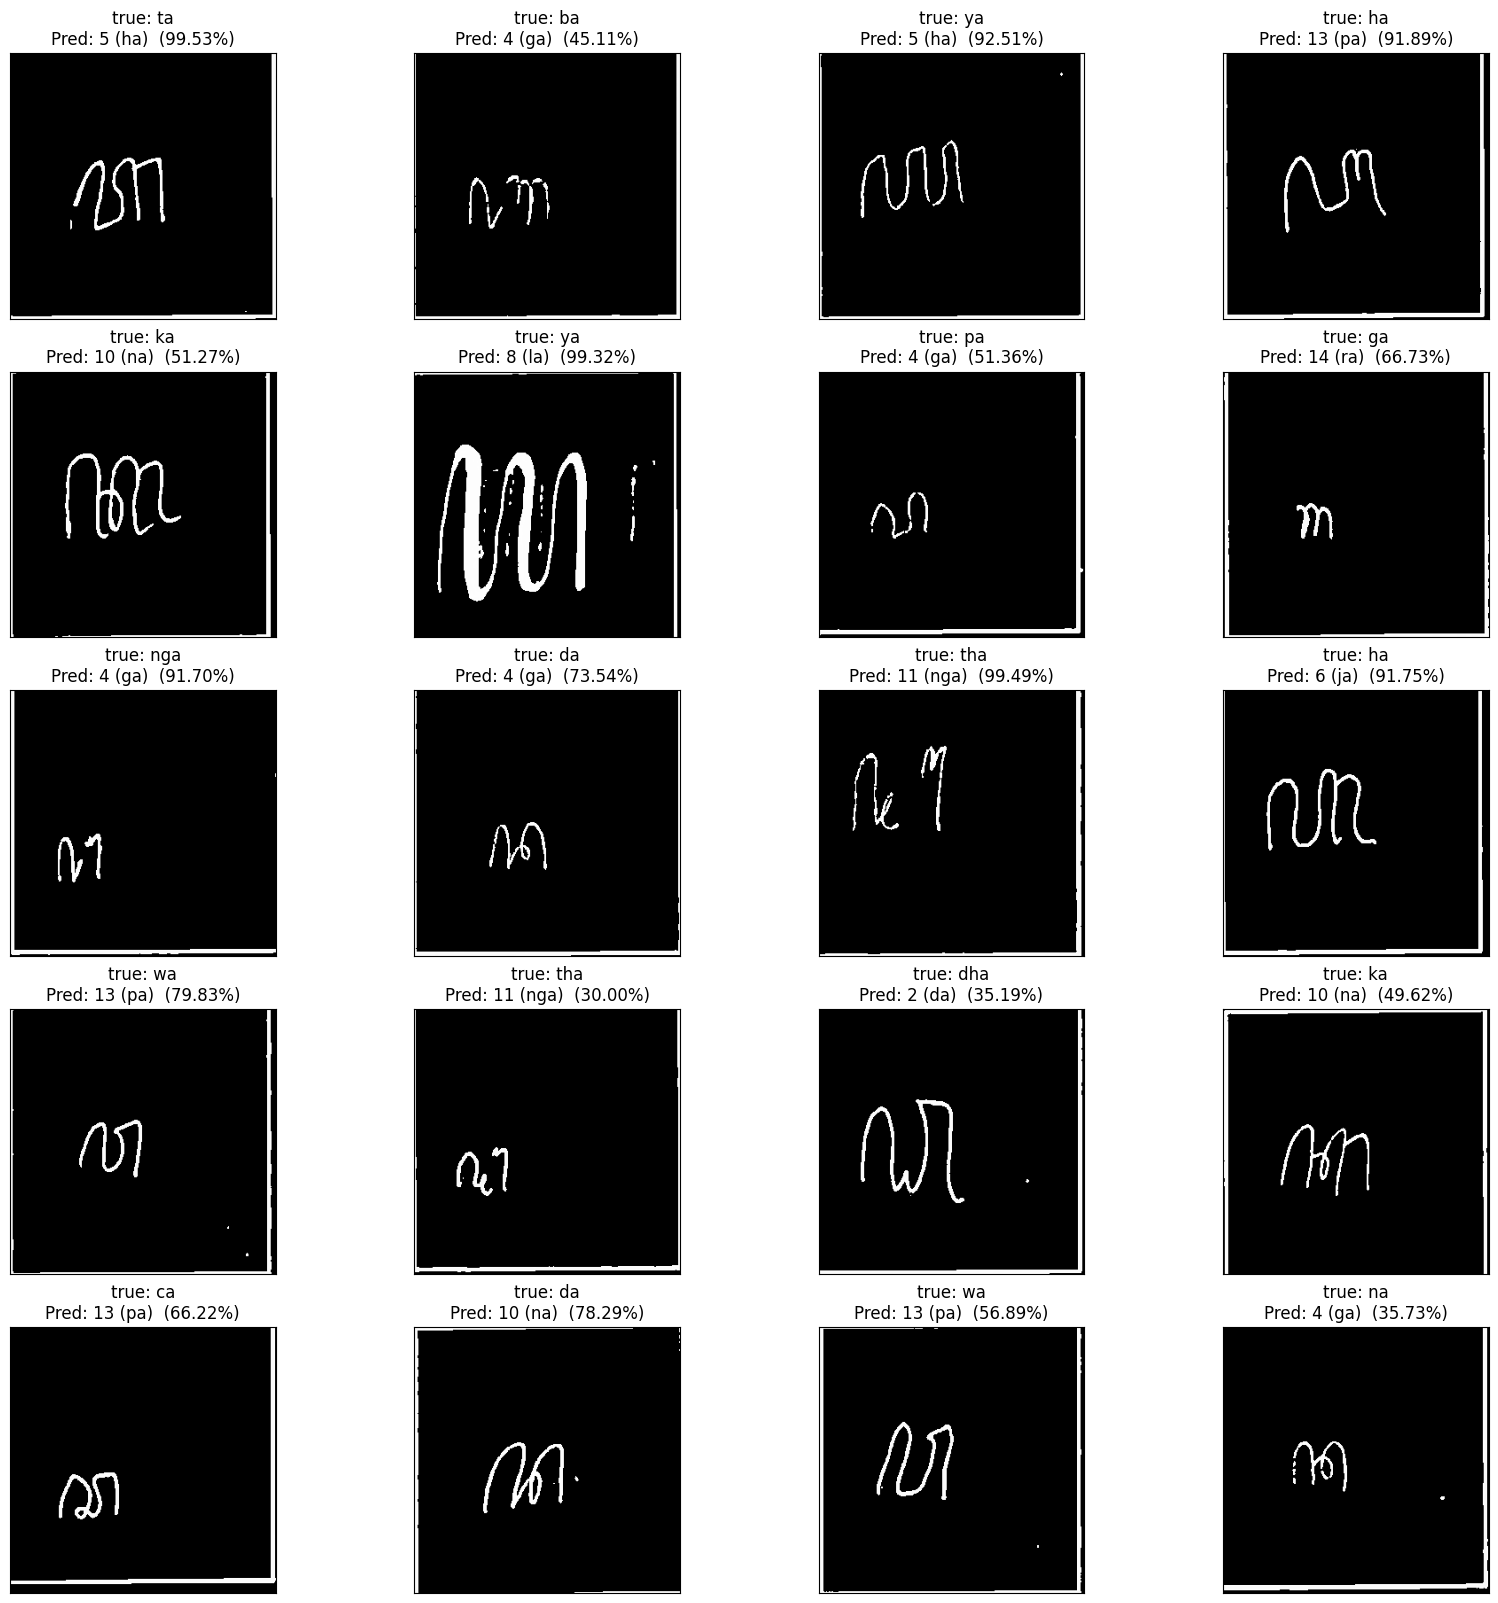

==== END MODEL 3 ====


==== MODEL 17 ====


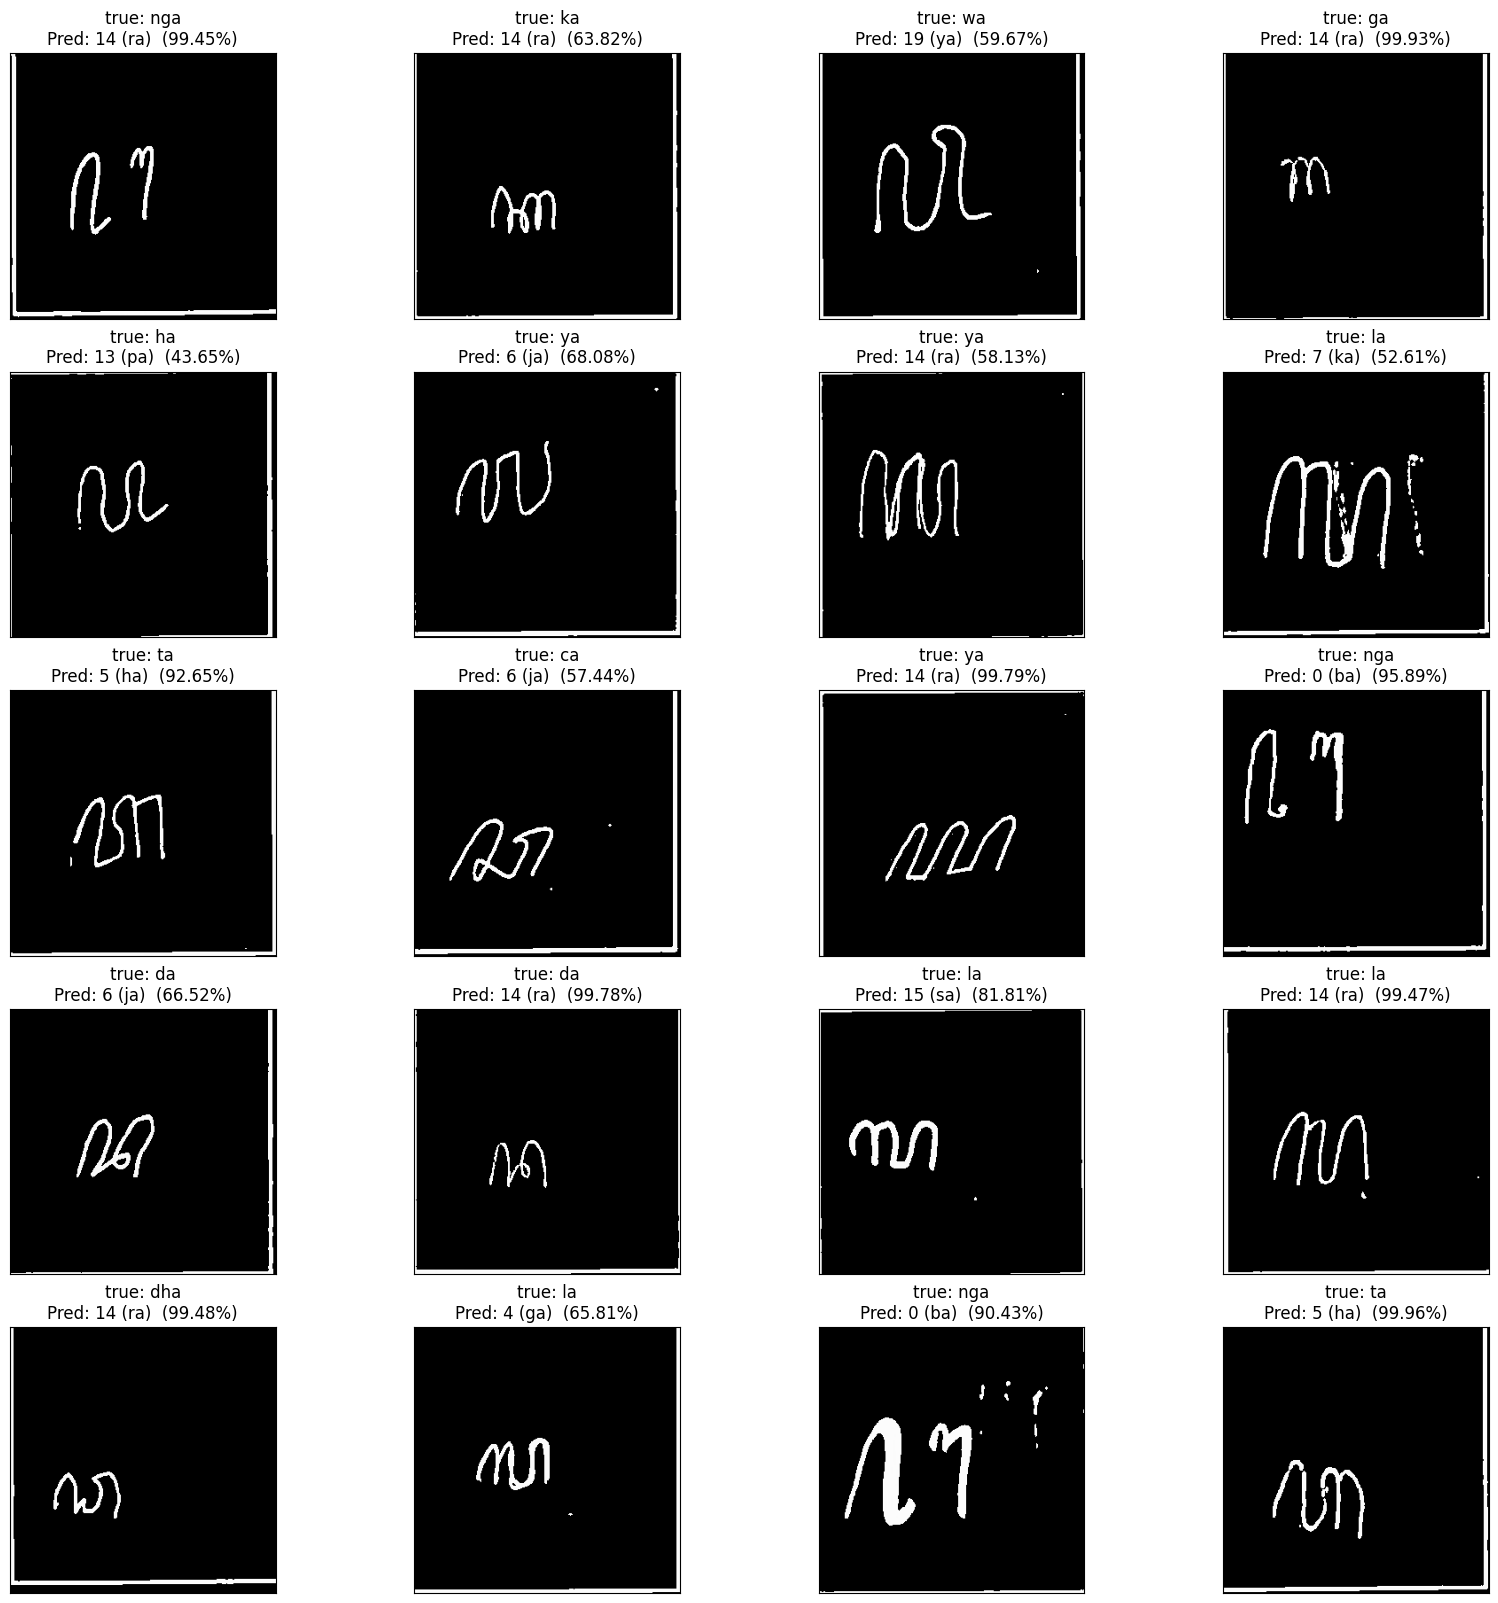

==== END MODEL 17 ====


==== MODEL 16 ====


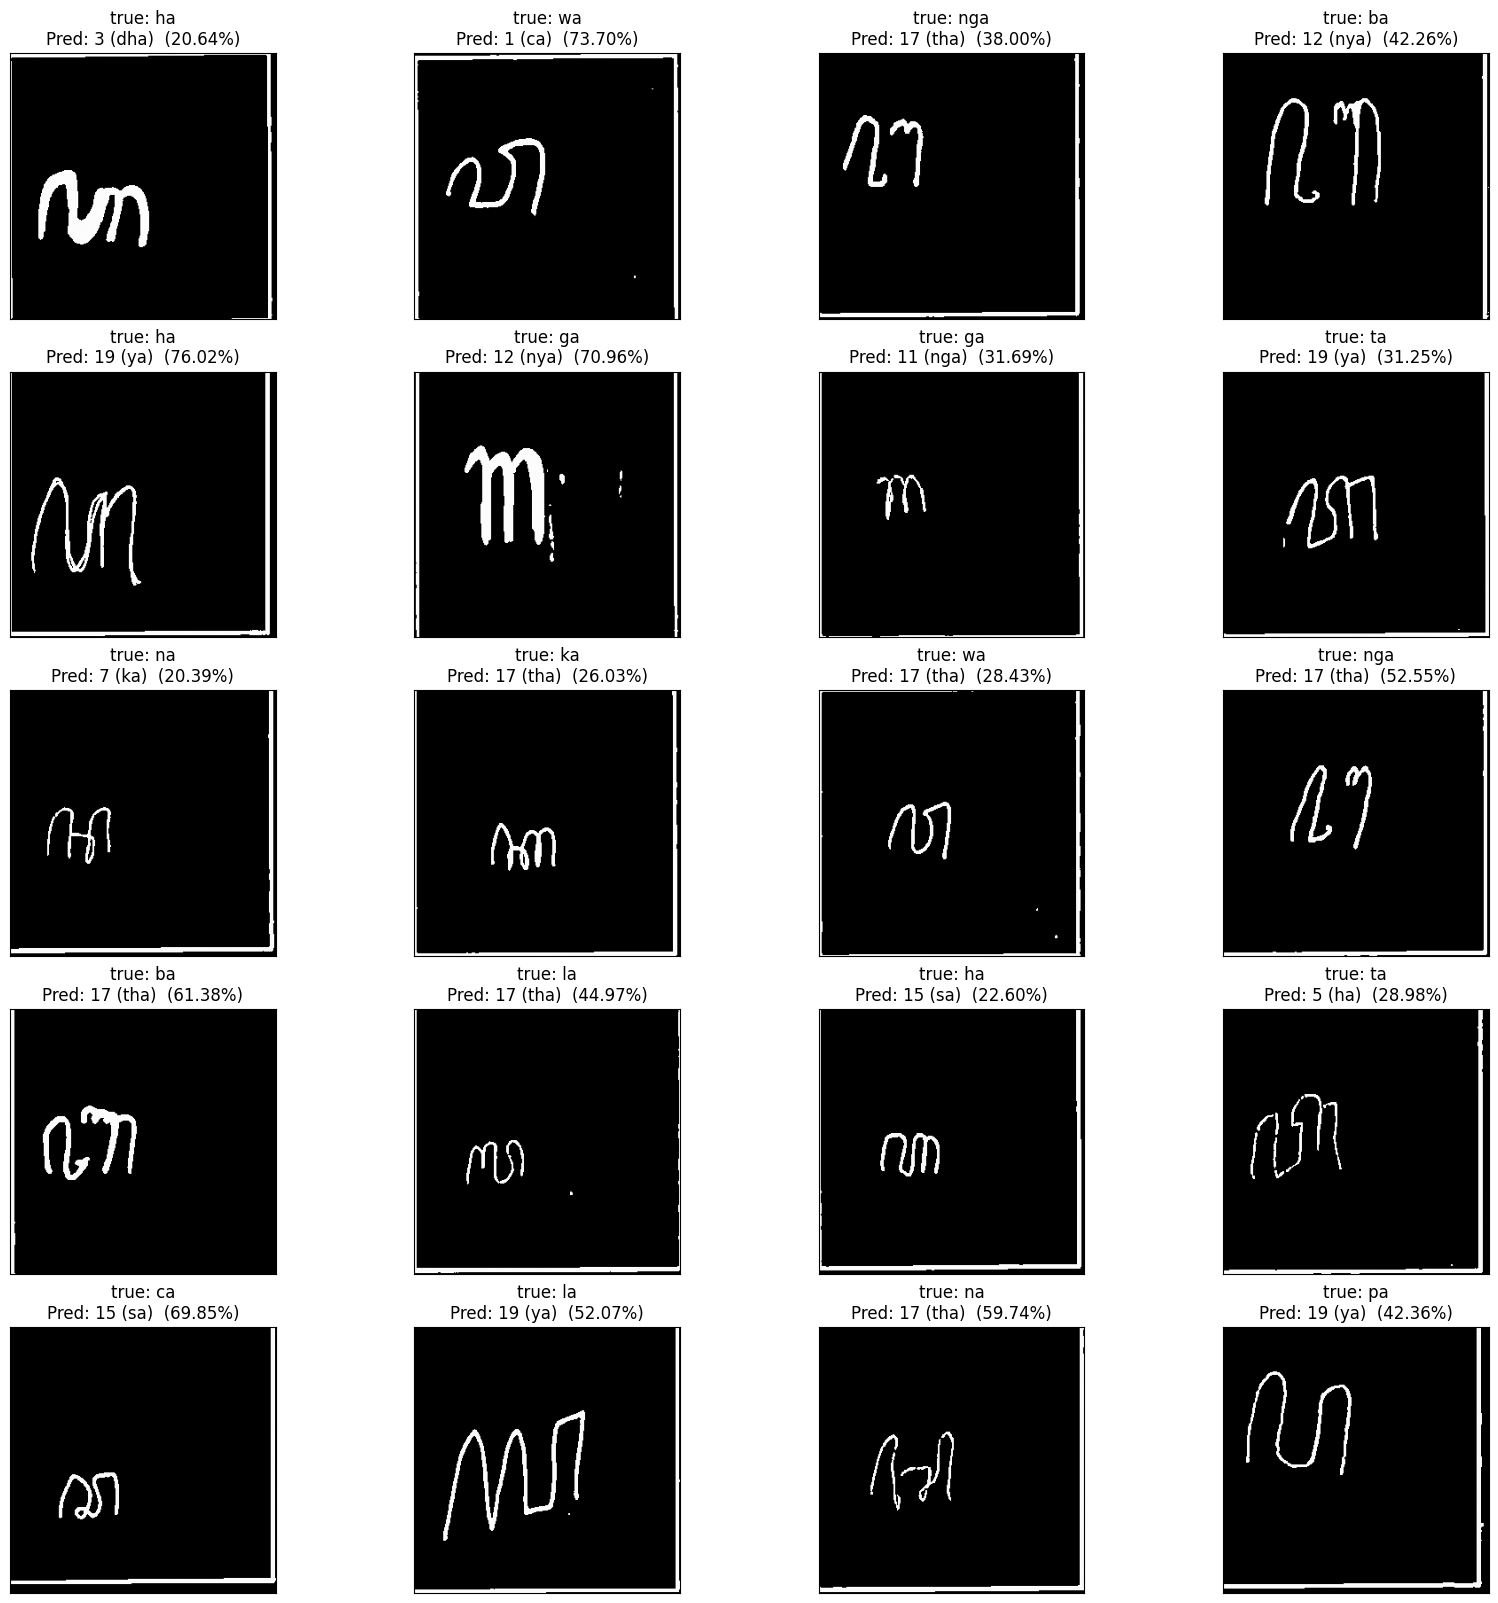

==== END MODEL 16 ====


==== MODEL 12 ====


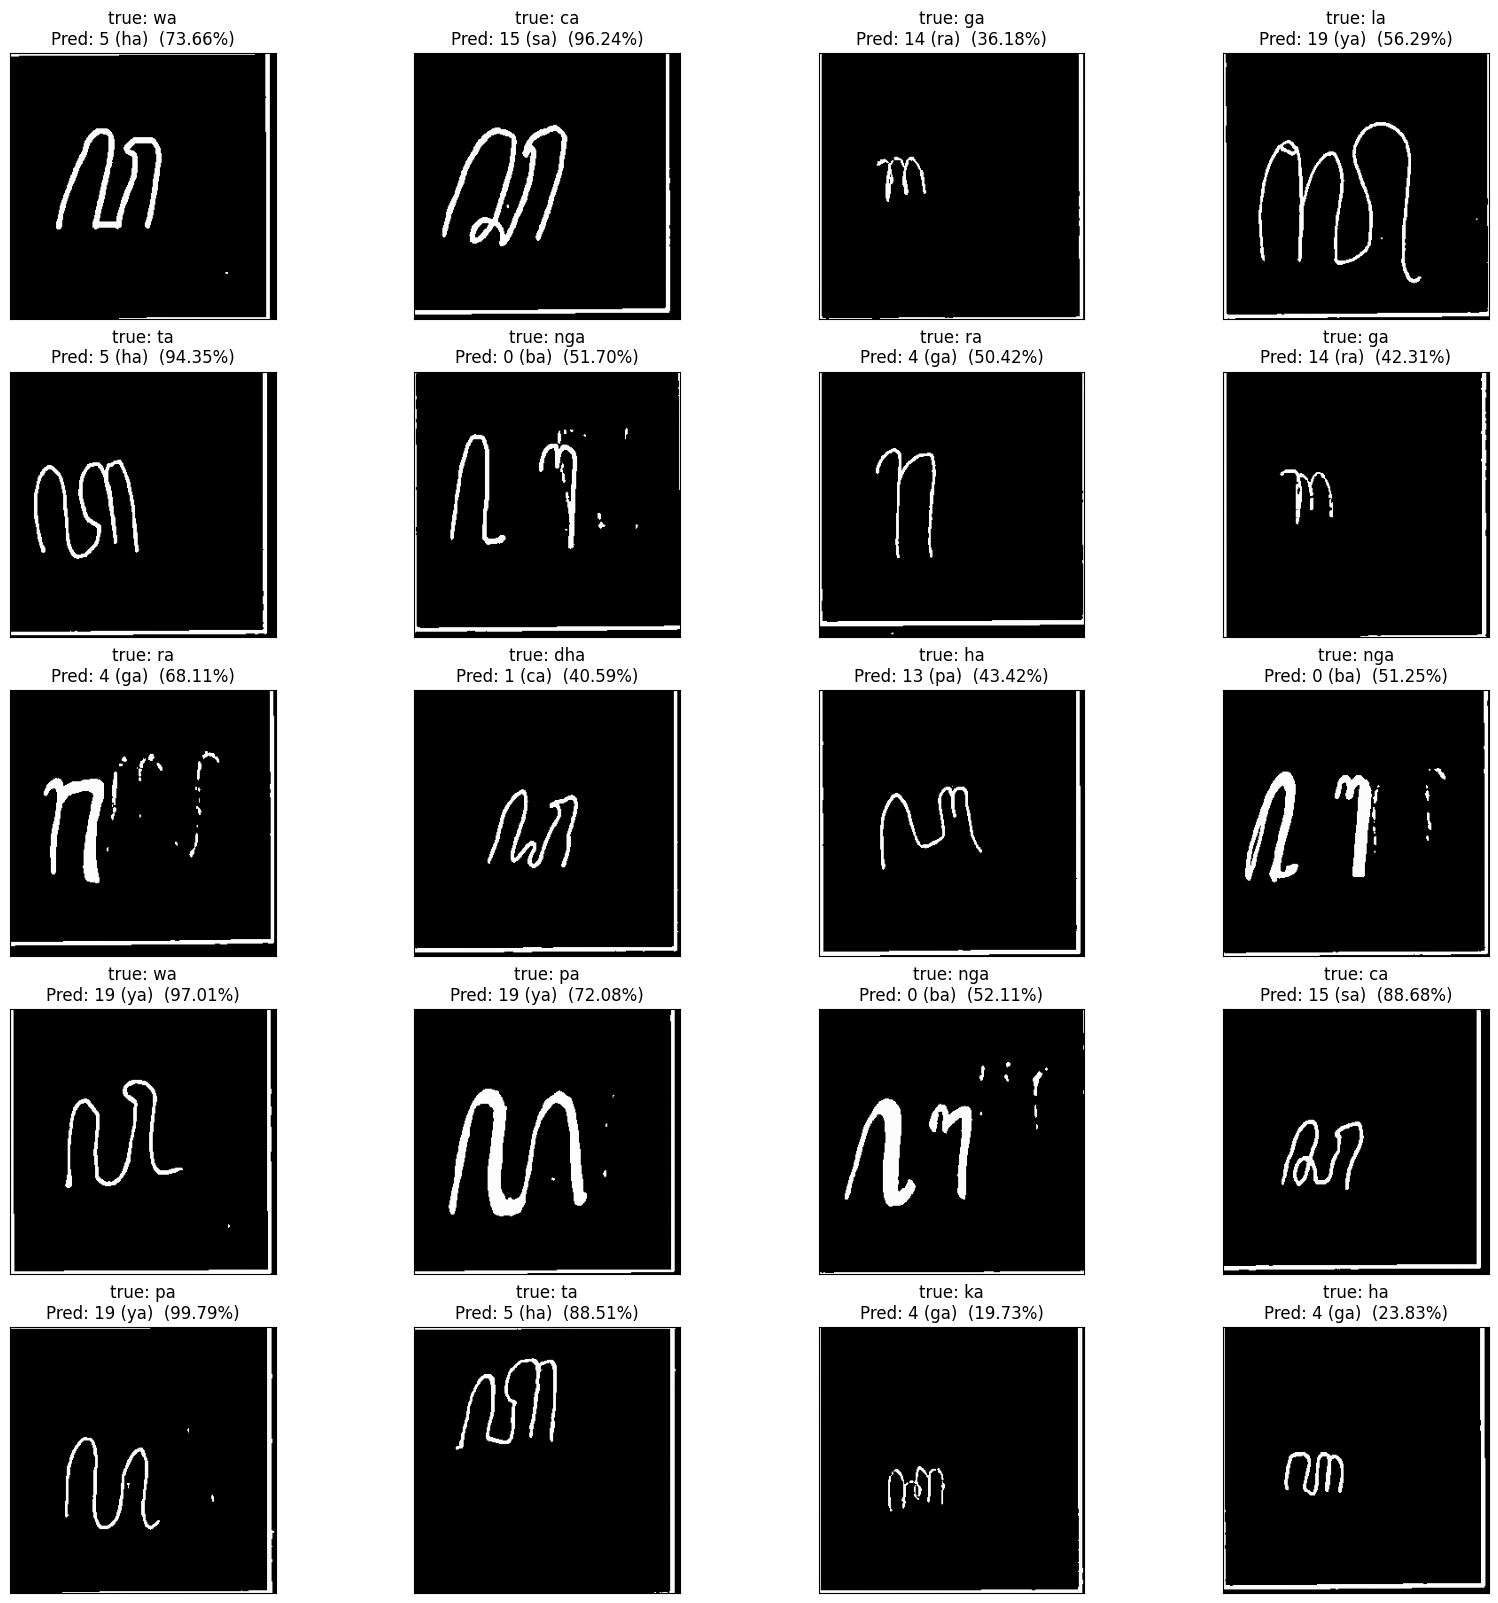

==== END MODEL 12 ====


==== MODEL 29 ====


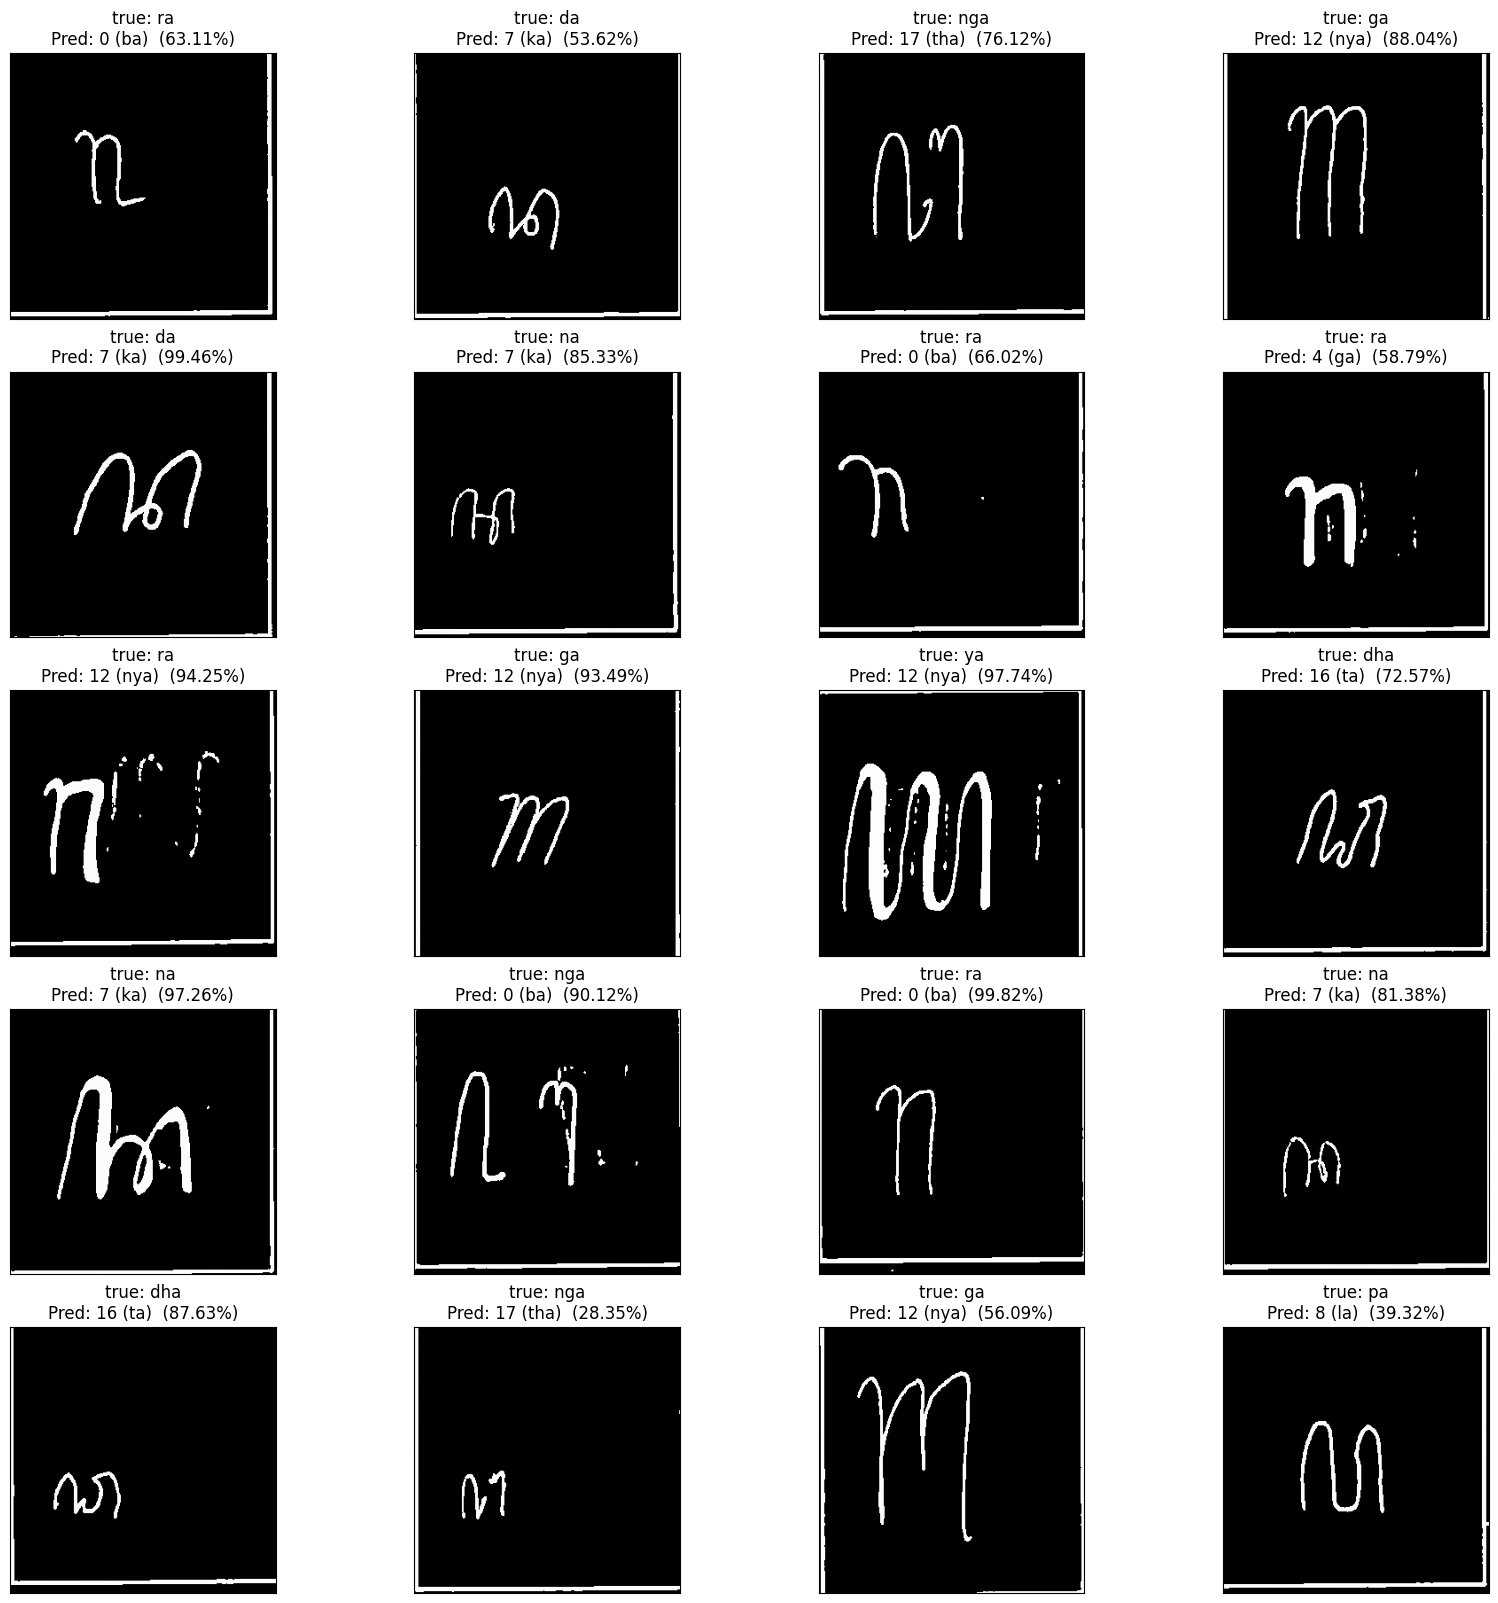

==== END MODEL 29 ====


==== MODEL 21 ====


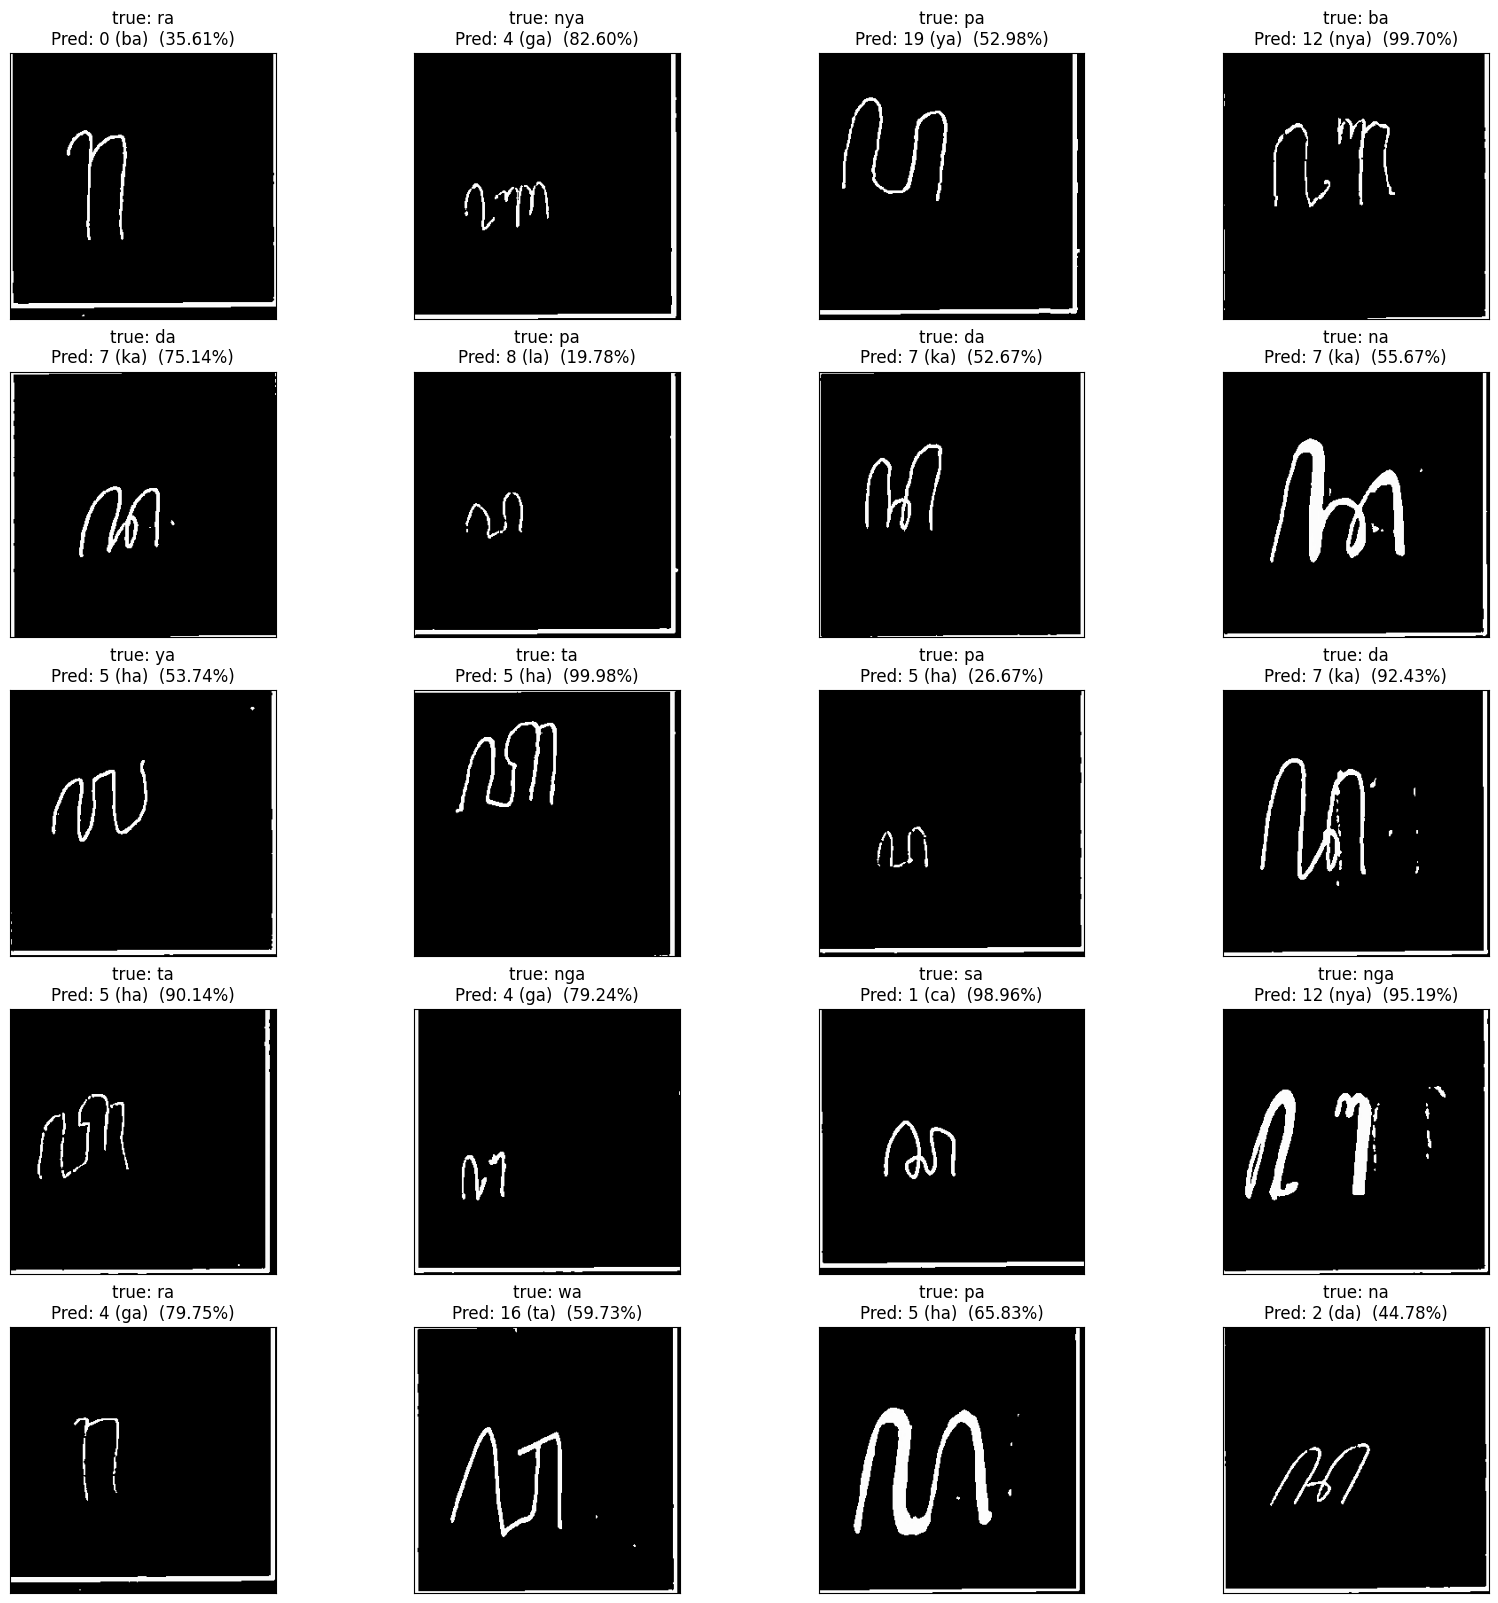

==== END MODEL 21 ====


==== MODEL 22 ====


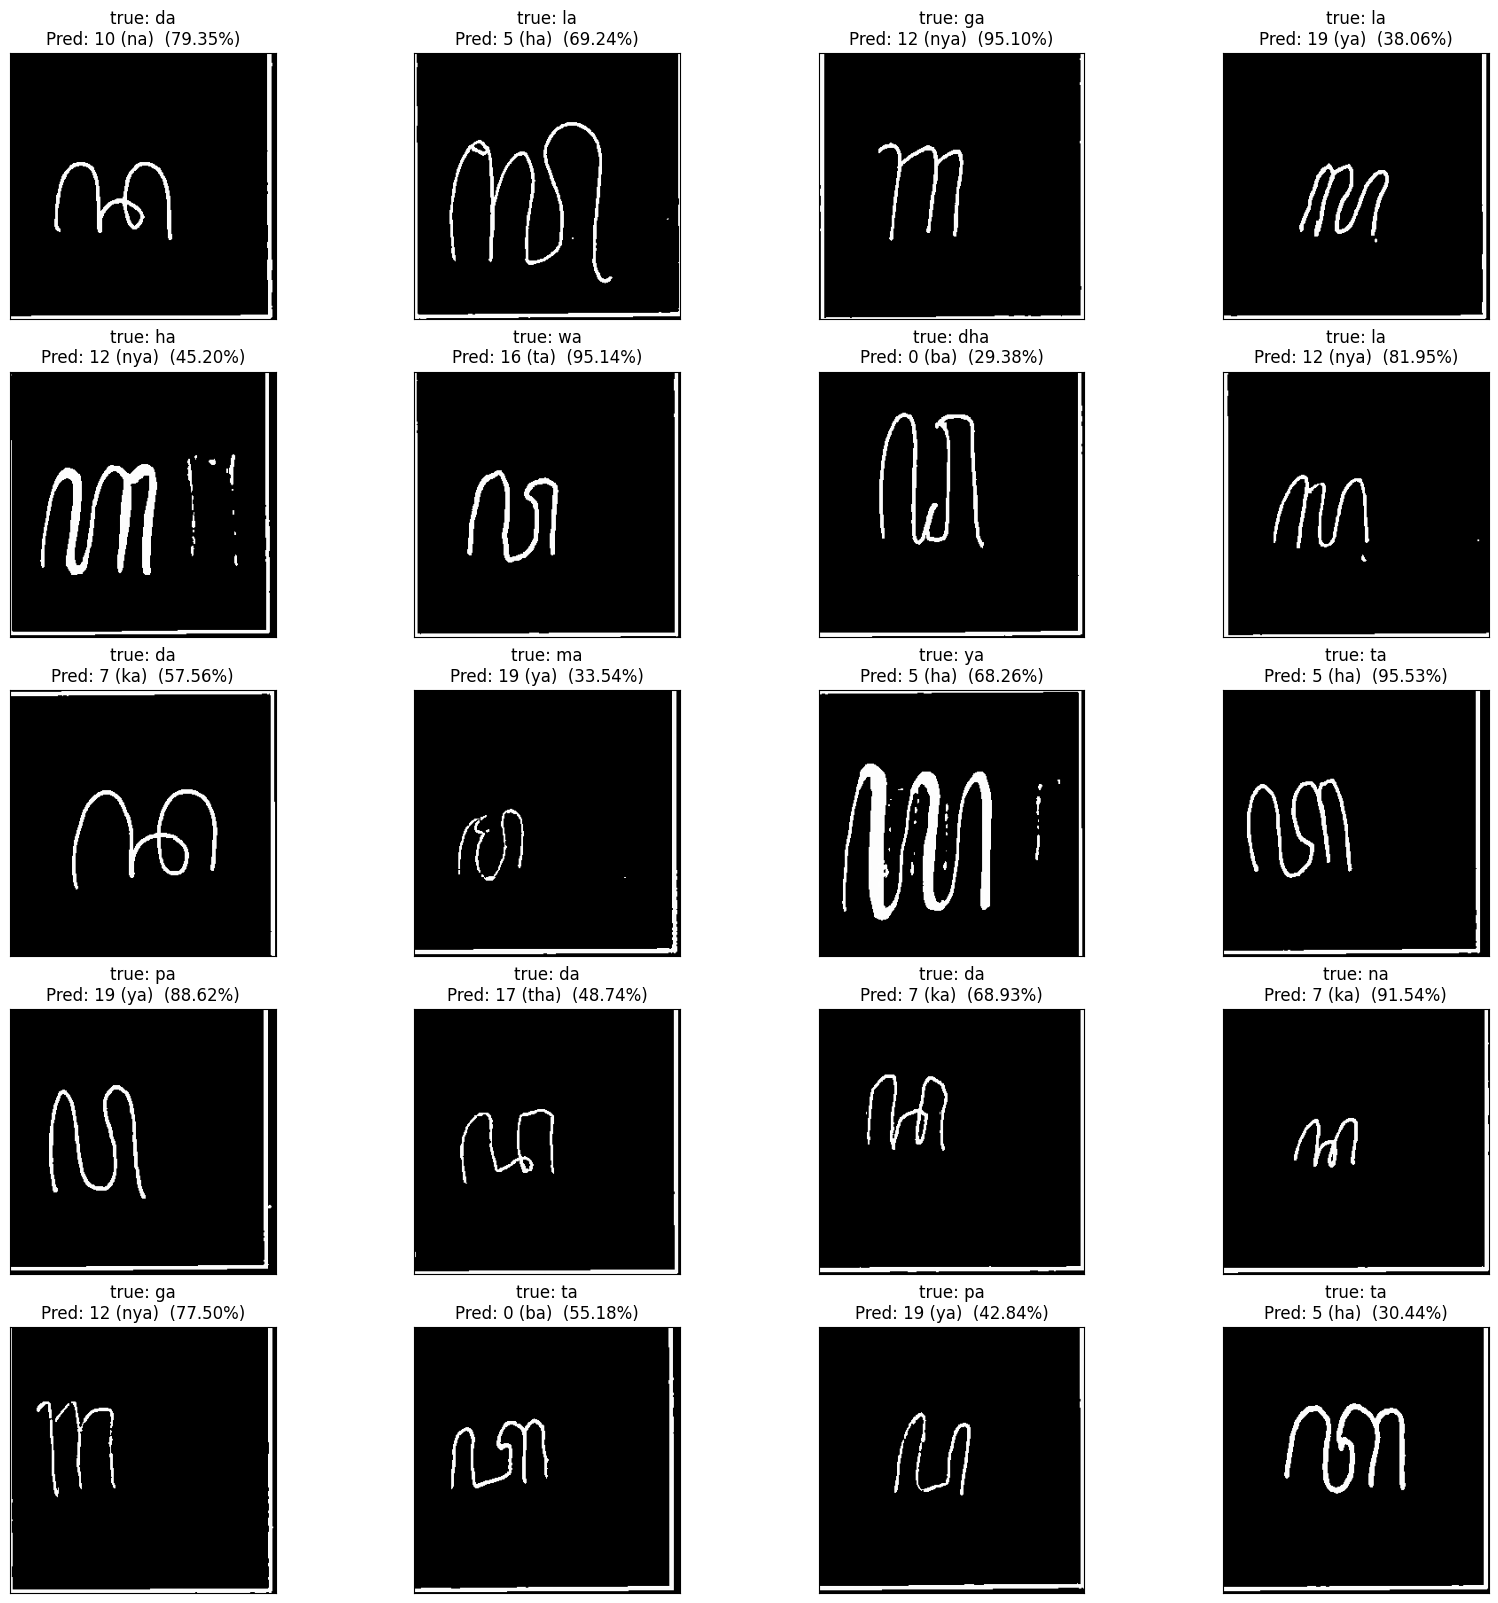

==== END MODEL 22 ====




In [14]:
for id, model in loaded_models.items():
    print(f'==== MODEL {id} ====')
    plot_images(real_test_ds_mapped, model=model, check=True, figsize=(20, 20), verbose=0)
    print(f'==== END MODEL {id} ====\n\n')

# Export Results

In [15]:
results

,model_id,loss,accuracy
0,6,1.490214,0.581081
1,1,0.406025,0.900000
2,3,0.817050,0.825676
3,17,1.460225,0.795946
4,16,1.110329,0.682432
5,12,0.632526,0.813514
6,29,1.673964,0.566216
7,21,0.706851,0.816216
8,22,1.647525,0.540541


In [16]:
results.to_csv('./top3_models_result.csv', index=False)

START predicting with model 1 ...
==== CONFUSION MATRIX FOR MODEL 1 ====
Accuracy: 90.00%


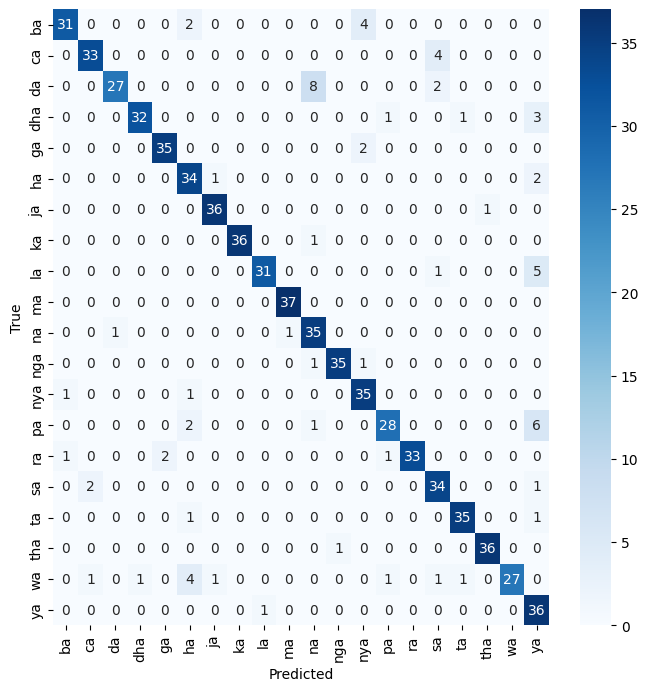

In [17]:
id = 1

print(f'START predicting with model {id} ...')

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in real_test_ds_mapped:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = loaded_models[id].predict(image_batch, verbose=0)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(f'==== CONFUSION MATRIX FOR MODEL {id} ====')
plot_confusion_m(correct_labels, predicted_labels, class_names, figsize=(8,8))